## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{(i,j)\in E} \sigma_i \cdot \sigma_j $$
such that :
$$ <x|H|x> = \sum_{(i,j) \in E} <x|\sigma_i \cdot \sigma_j|x> = \sum_{(i,j) \in E} <x|I \otimes ... \otimes \sigma_z \otimes ... \otimes ... \otimes \sigma_z \otimes ... \otimes I|x> = \sum_{(i,j) \in E} (1-2x_i)(1-2x_j)$$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    
    val = 0
    
    for edge in edges:
        val += (1 - 2*b[edge[0]])*(1 - 2*b[edge[1]])   #We compute the cost function thanks to the previous formula

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

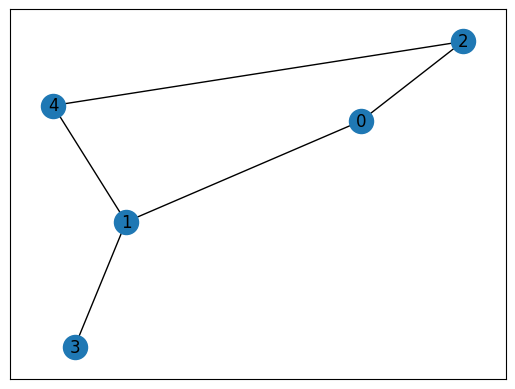

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits):
        layer.apply(RX(theta), i)    #We first apply the RX(theta) door to all of the qbits
        
    for edge in edges:
        layer.apply(U_ZZ(beta), edge[0], edge[1])   #Then we apply the U_ZZ door according to the computation of exp(-i*Hamiltonian)

    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    
    for i in range(n_qubits):
        prog.apply(H, qubits[i])
    
    for p in range(n_layers):
        layer = one_qaoa_layer(n_qubits, edges, parameters[2*p], parameters[2*p + 1])   #We apply the QAOA algorithm
        prog.apply(layer, qubits)


        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        hamiltonian = 0
        bits = sample.state.bitstring
        for edge in edges:
            hamiltonian += (1 - 2*int(bits[edge[0]]))*(1 - 2*int(bits[edge[1]]))
                            
        obs += sample.probability * hamiltonian    #We compute the observable and multiply it by the probabality of the state
    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.09065128, 0.43383071, 0.86763089])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:
The optimal value seems to be reachable with 8 layers and more.

0.36474803968670305 -0.5381282187376737 -0.7962508892035819 -1.7390289430135937 -1.8880511392067079 -2.0716480446166488 -2.866085304393941 -2.9317005215512038 -3.653104293548569 -3.709581692266911 -3.810137141462885 -3.9624940309915844 -4.103917021193974 -4.109404564667086 -4.154133766013508 -4.209508506276943 -4.233667109173178 -4.2512862915396274 -4.278136448080057 -4.301502443922903 -4.325553461522373 -4.352549041650205 -4.367163597714235 -4.391085183532646 -4.425712872616128 -4.455900086657754 -4.495200695130742 -4.544457173772114 -4.582181977234342 -4.600904513702623 -4.627473354096921 -4.636318037498131 -4.637353279191916 -4.6393010776347365 -4.6427761354920385 -4.647989577330153 -4.650760201876959 -4.651477634384493 -4.651891947600807 -4.652163767405833 -4.652648257439922 -4.656871831118823 -4.6601482992934065 -4.662240253485036 -4.6661711852467604 -4.673410538835309 -4.685022665987096 -4.689853086242543 -4.691826010155026 -4.692303577290624 -4.692728081600843 -4.69335006043416 

0.8133244271897533 -0.10362309895694405 -0.3985938769780379 -0.8149689501386861 -1.0519579366965635 -1.2059674682709127 -1.255836889102943 -1.3494779164034438 -1.8064079631551155 -1.9344699505969785 -2.120867950699868 -2.2194611275229894 -2.6358693020729156 -2.7648361817562104 -2.99944655722216 -3.3032213830324997 -3.6547250815647043 -3.725088189396292 -3.8428676706741762 -3.974725841063459 -4.042374443217824 -4.072869149857548 -4.124479513633002 -4.19902088587217 -4.216041725782113 -4.243696188326091 -4.2809440354425945 -4.304352694943175 -4.315359983086933 -4.328228191441906 -4.343323028963645 -4.367976126022366 -4.388624588612872 -4.419204171735655 -4.467766610104527 -4.491532005266745 -4.52816752712201 -4.553096962982309 -4.5869706603556315 -4.608209528551648 -4.6400158903052695 -4.681356535640681 -4.724572664223697 -4.764199809304375 -4.7813359833855165 -4.793343583252102 -4.801144752569202 -4.809662319776454 -4.8243832935284585 -4.840918635475194 -4.85075719055471 -4.858740866272

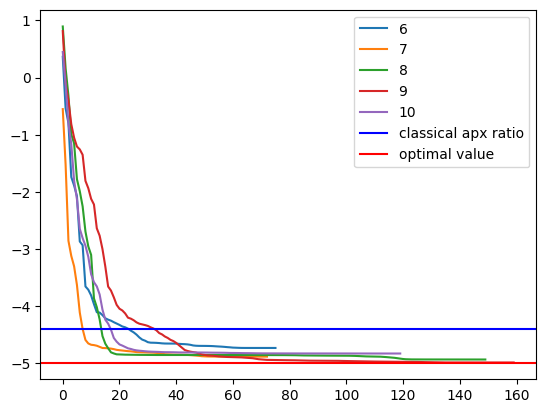

In [9]:
import matplotlib.pylab as plt


for nlayers in range(6,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
    print(back_trace)
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

-1.8599369077996482 -1.9792523533548836 -2.8654345684255524 -3.0939372268869554 -3.395025848226295 -3.732997837684537 -3.8893553185451317 -3.9693434650385058 -3.9774241021621286 -3.9781781798176747 -3.978268662333385 -3.978269027568124 -3.9782690296525334 -1.7485106399262542 -1.814401169276661 -2.317278396995238 -3.2096713154572565 -3.6092504532587 -3.887046846554727 -4.248442671828189 -4.424086567484247 -4.494829808484996 -4.575615817074385 -4.631385888126022 -4.651671317000842 -4.66176660553606 -4.66243381722271 -4.6625681833025 -4.662589557600598 -4.662589583758029 -4.662589588287367 -1.6251857269860996 -2.273513965294204 -2.9833991462225296 -3.3955253682715223 -4.116335742866135 -4.378782897632664 -4.433853035227854 -4.508457954775672 -4.5287568794269255 -4.564471920895063 -4.6242858646891065 -4.657137857782042 -4.666534998492805 -4.674533752188231 -4.687687162219589 -4.704480564502732 -4.71092390622371 -4.714146519502533 -4.714844865829838 -4.715190505283326 -4.715628256467575 -4.

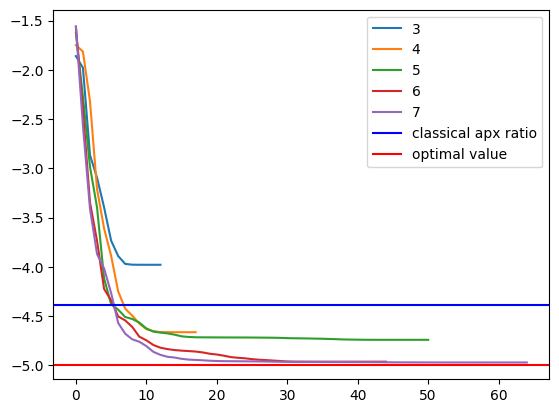

In [10]:
T = 1.

for nlayers in range(3,8,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(nlayers):
        thetak = 2*T*(nlayers-k)/nlayers**2
        betak = k*T/nlayers**2
        parameters_init.append(thetak)
        parameters_init.append(betak)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

We used the following approximation :
$$\begin{align*}
\int_{0}^{T}H(s) \mathrm{d}s  &= \sum_{k = 0}^{p} \frac{T}{p} H(\frac{kT}{p}) \\
&= \sum_{k = 0}^{p} \frac{T}{p} \left(\left(1 - \frac{k}{p}\right)H_0 + \frac{k}{p}H_{C}\right) \\
&= \sum_{k = 0}^{p} \frac{T(p - k)}{p^2}H_0 + \frac{kT}{p^2}H_C
\end{align*}$$
where :
$$H_0 = \sum_{i} \sigma_i^x$$
Hence :
$$\exp \left(-i\int_{0}^{T}H(s) \mathrm{d}s \right) = \prod_{k = 0}^{p} \exp \left(-i\frac{T(p - k)}{p^2}H_0\right) \exp \left(-i\frac{kT}{p^2}H_C\right)$$
and :
$$
\begin{align*}
\exp \left(-i\frac{T(p - k)}{p^2}H_0\right) &= \prod_{i} \exp \left(-i\frac{T(p - k)}{p^2}\sigma_i^x \right) \\
&= RX\left(\frac{2T(p - k)}{p^2} \right)
\end{align*}
$$
Therefore, we can finally identify :
$$
\begin{align*}
\theta_k &= \frac{2T(p - k)}{p^2} \\
\beta_k &= \frac{kT}{p^2}
\end{align*}
$$